# Birdometer - machine learning playground
Project by Freija D. September 2017


## What is the birdometer?
The birdometer is a hummingbird feeder that I instrumented with:
 - a Raspberry Pi
 - a Raspberry Pi camera
 - an IR sensor
 
The birdometer is currently set up to take 5 images whenever the IR sensor triggers. The Raspberry Pi code runs in a Docker. The code can be found here: https://github.com/Freija/birdometer-rpi


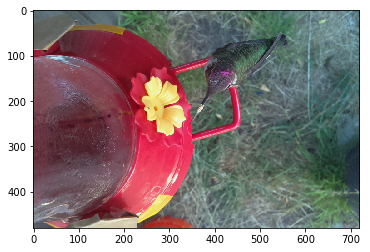

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# Plot one of the images as illustration
imgplot = plt.imshow(mpimg.imread('../trainingdata/2017-09-21_16.06.01_9.jpg'))
plt.ion()
plt.show()
# This is a male Anna's hummingbird with some pollen stuck to his beak, considering taking a sip.


## What is the goal?
The first goal is to monitor the visits of the hummingbirds to the feeder, basically to record the time of each visit. This will allow us to check some interesting statistics:
 1. How often does a bird visit?
 2. What times of the day are most popular?
 3. Is there a correlation with temperature? Sun/rain/wind?
 4. Is is possible to predict the number of visits for a particular day or other time metric?
 5. Etc.
 
The data will be displayed on a website containing a bird-timeline showing the time of each visit and also the associated images for each visit. A challenge is that the IR sensor often triggers without a hummingbird in the vicinity. An image classifier needs to be trained and deployed to 

The next step is to try out hummingbird facial recognition: can I distinguish between different individual birds? For this, I can add other sensors to the birdometer, like for example an acoustic sensor. Maybe wing-beat speed varies between different birds? It is also possible to add an additional camera to capture images or video at a different angle.

## Image classification steps and status
Steps of the image classification process:

- [x] Label a set of images. This is done using a python script (handscan.py). I labeled over 3500 images. It takes about 5 seconds per image.
- [x] Divide the labeled data into a training set (80%), cross validation set (10%) and test set (10%). The test set will be used after the classifier is fine-tuned to determine the expected precision of the classifier.
- [/] Test out different classifiers algorithms to detect if there is a bird in the image or not. Working on this now:
   - [x] kNN
   - [ ] logistic regression
   - [ ] neural network
   - [ ] support vector machine
- [ ] Decide on classifier, train and use the test-set to validate.
- [ ] Deploy the trained algorithm on the Raspberry Pi to classify new images. Do not save any image that does not have a bird.

## Bunch imports here

In [3]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import image
from sklearn.metrics import f1_score, classification_report, precision_recall_fscore_support
import numpy as np
import pandas as pd
import cv2
import os
from os.path import join
import csv
import random

## Helper functions

In [4]:
def image_to_vector(image, size):
    ''' Vectorize the given image according to the requested size.
    Inputs:
        <string> path to image
        <tuple> two integers: (width, height)
    Returns:
        <numpy array>: the vectorized image
    '''
    image_array = cv2.imread(image)
    return cv2.resize(image_array, size).flatten()  # This is a numpy array

In [5]:
def get_image_list(path):
    ''' Retrieve the list of available labeled images.
    Input:
        <string> path to CSV file
    Output:
        <list> a list of lists like this: ['2017-09-20_17.04.43_9.jpg', 'y', 'n'] 
    '''
    image_list = []
    with open(path, 'r') as infile:
        reader = csv.reader(infile)
        for row in reader:
            image_list.append(row)
    return image_list

In [6]:
def get_label(image_detail):
    ''' Return the label of the image.
    Input:
        <list> image details like this: ['2017-09-20_17.04.43_9.jpg', 'y', 'n'] 
    Output:
        <int>  the label of the image : 0 (no bird), 1 (bird), -1 (unknown)
    '''
    # The label needs to be 1 if image_detail[1]=='y' and 0 if not.
    if image_detail[1] == 'y':
        return 1
    elif image_detail[1] == 'n':
        return 0
    else:
        return -1  # Something is wrong

## Image preprocessing

In [7]:
# Get the list of available training images
image_list = get_image_list('/home/freija/Projects/birdometer-ml/trainingdata/images.handscan.csv')
print('Total number of labeled images is {}.'.format(len(image_list)))
print('First image details are {}'.format(image_list[0]))

Total number of labeled images is 3860.
First image details are ['2017-09-20_17.04.43_9.jpg', 'y', 'n']


In [8]:
# Extract the feature vectors for each image and store
features = []
labels = []
images = []
red_fac = 10
for image in image_list:
    image_path = '/home/freija/Projects/birdometer-ml/trainingdata/' + image[0]
    label = get_label(image)
    # Ignore any label that is not 1 or 0
    # If the label is unknown, get_label returns -1 and the image
    # should be ignored since something went wrong when labeling.
    if label != -1:
        features.append(image_to_vector(image_path, (int(720/red_fac),int(480/red_fac))))
        labels.append(label)
        images.append(image)

In [9]:
print('Total number of correctly labeled images is {}.'.format(len(features)))

Total number of correctly labeled images is 3858.


## Having a look at a few images

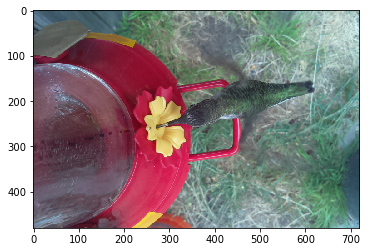

In [10]:
# Let's compare before/after we do the vectorization, oh, and it should be images with a bird in it, for fun!
# Find all the images with birds
bird_images = [image_detail[0] for image_detail in image_list if get_label(image_detail) == 1]
# Plot a random one, this way, I can reload the cell to flip through some examples
random_image = random.choice(bird_images)
imgplot = plt.imshow(mpimg.imread(join('../trainingdata/', random_image)))
plt.ion()
plt.show()

(48, 72, 3)


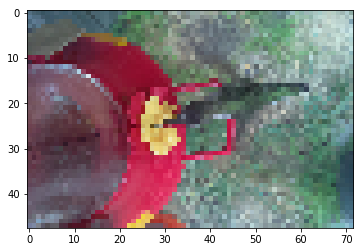

In [11]:
# The images are 720x480 pixels RGB, this means that the maximum number of features is 1036800.
# The pre-processing reduces this by reducing the number of pixels but keeping the RGB information.
random_image_path = '/home/freija/Projects/birdometer-ml/trainingdata/' + random_image
image_array = cv2.imread(random_image_path)
resized_image_array = cv2.resize(image_array, (int(720/red_fac),int(480/red_fac)))
print(resized_image_array.shape)
# resized image array is a matrix
plt.imshow(cv2.cvtColor(resized_image_array,cv2.COLOR_BGR2RGB))  # cv2 uses BGR convention
plt.show()

### Notes
Clearly, the image above is very pixelated and the color of the bird is similar as the background in most cases. I am keeping this for now, knowing that I will be able to easily change the number of features in the future as part of the classifier optimization. Things to try:
 * increase number of pixels, by decreasing red_fac
 * cut away parts of the image that have the feeder.

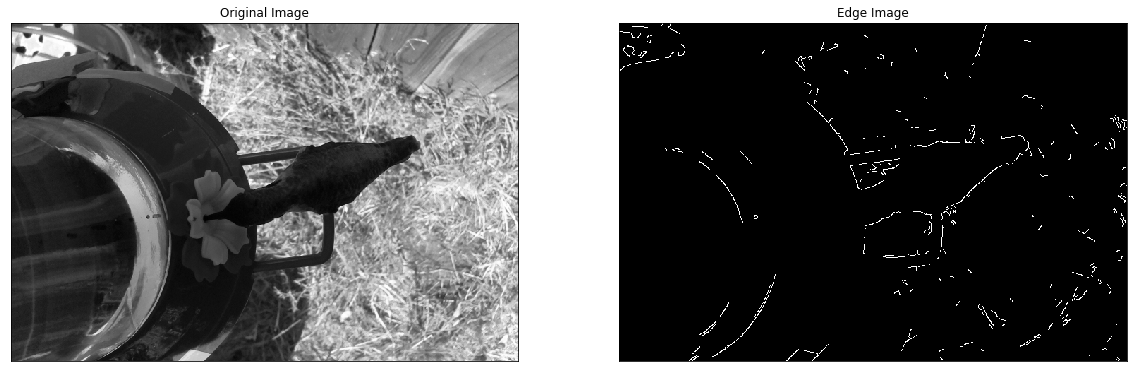

In [12]:
# Let's see if we can reduce this to edges
# Using OpenCV
random_image = random.choice(bird_images)
random_image_path = '/home/freija/Projects/birdometer-ml/trainingdata/' + random_image
img = cv2.imread(random_image_path,0)
edges = cv2.Canny(img,300,500)
plt.figure(figsize=(20,20))
plt.subplot(121),plt.imshow(img,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])

plt.show()

## Splitting the labeled data

In [13]:
# Time to split up our data in a training, validation and test-set. We want to do 80%,
# 10%, 10%.
# We can call train_test_split twice. 
x, X_test, y, y_test = train_test_split(features,labels,test_size=0.2,train_size=0.8, random_state = 0)
X_train, X_cv, y_train, y_cv = train_test_split(x,y,test_size = 0.25,train_size =0.75, random_state = 0)
print(len(X_train), len(X_cv), len(X_test))

2314 772 772


## A deeper look at the data
By doing dimensionality reduction, we can try to understand the data a bit better. Is there a clear separation between bird/non-bird pictures? If not, why not? What are the problem images and is there any other processing we can do to improve separation?

### PCA
Let's use PCA to visualize the data reduced to two dimensions, plotting the first two principal components.

[[-0.91417182 -0.58942785]
 [-0.89699201 -0.4845832 ]
 [ 1.46956781 -0.69136304]
 ..., 
 [ 0.75530256  1.68071311]
 [-0.9731793  -0.44735164]
 [ 1.47716717 -0.74164393]]


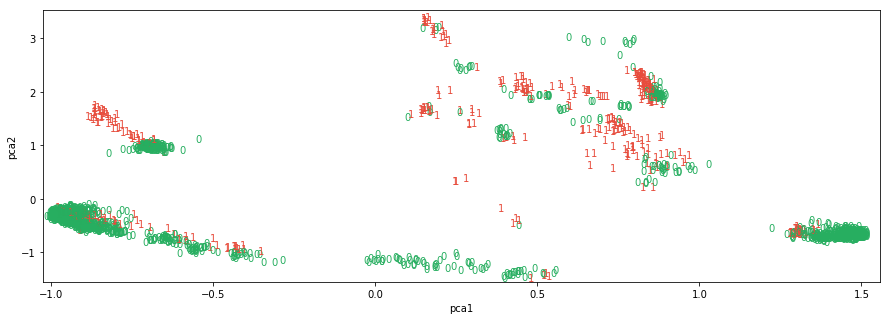

In [18]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2, svd_solver='randomized',
          whiten=True).fit(X_train)
birds_pca = pca.transform(X_train)
print(birds_pca)
colors = ["#27AE60", "#E74C3C"]
plt.figure(figsize=(15,5))
plt.xlim(birds_pca[:,0].min(), birds_pca[:,0].max() + 0.05)
plt.ylim(birds_pca[:,1].min(), birds_pca[:,1].max() + 0.2)
for i in range(len(birds_pca)):
    plt.text(birds_pca[i,0], birds_pca[i,1], str(y_train[i]), color=colors[y_train[i]])
plt.xlabel("pca1")
plt.ylabel("pca2")

**Interpretation**

From the two-dimensional plot showing the two principal components above, it is clear that there are different clusters of images and within each cluster, both class 0 (no bird, green) and class 1 (bird, red) are represented typically. We can understand this as follows:

 * The images have differences in shading and contrast depending on wether the sun is out or on the time of day.
 * Each cluster is likely a cluster of images taken in similar lighting (time of day, shade, sun).
 * Within a group of images taken in similar conditions, there are images with and without birds.
 
Let's look at a few images to investigate. Specifically, there are two interesting groups:

 - **group 1**: pca1 < -0.5 and pca2 > 0.5. The classes are pretty well separated in this grouping.
 - **group 2**: pca1 > 1.0 and pca2 < 0.0. The classes seem less well separated in this grouping. 

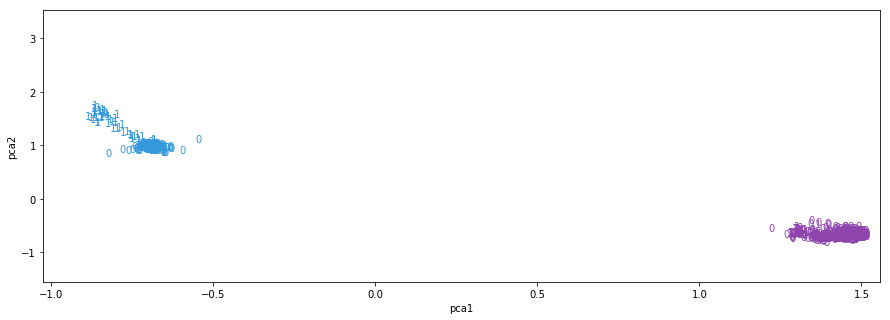

In [19]:
# First, grab the list of images in each group.
# The image names are in the images list.
# Also plot them to make sure we are selecting correcly
# Group 1 is blue and group 2 is purple
plt.figure(figsize=(15,5))
plt.xlim(birds_pca[:,0].min(), birds_pca[:,0].max() + 0.05)
plt.ylim(birds_pca[:,1].min(), birds_pca[:,1].max() + 0.2)
for i in range(len(birds_pca)):
    if (birds_pca[i,0] < -0.5) and (birds_pca[i,1] > 0.5):
        plt.text(birds_pca[i,0], birds_pca[i,1], str(y_train[i]), color="#3498DB")
    if (birds_pca[i,0] > 1.0) and (birds_pca[i,1] <0.0):
        plt.text(birds_pca[i,0], birds_pca[i,1], str(y_train[i]), color="#8E44AD")
plt.xlabel("pca1")
plt.ylabel("pca2")

In [ ]:
# Let's look at the images in these groups


### t-SNE
t-distributed Stochastic Neighbor Embedding or t-SNE can be used to visualize high-dimensional data. I am using the sklearn implementation here. From sklearn docs: ```It converts similarities between data points to joint probabilities and tries to minimize the Kullback-Leibler divergence between the joint probabilities of the low-dimensional embedding and the high-dimensional data. t-SNE has a cost function that is not convex, i.e. with different initializations we can get different results.```

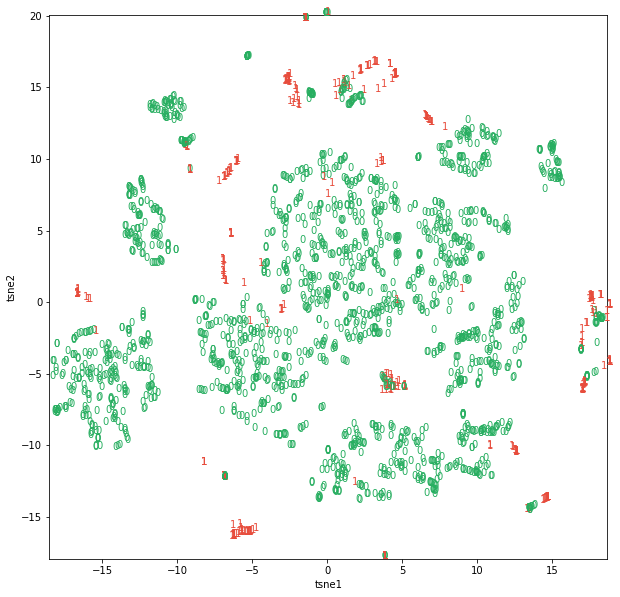

In [72]:
from sklearn.manifold import TSNE
tsne = TSNE(random_state=48)
birds_tsne = tsne.fit_transform(X_train)
plt.figure(figsize=(10,10))
plt.xlim(birds_tsne[:,0].min(), birds_tsne[:,0].max())
plt.ylim(birds_tsne[:,1].min(), birds_tsne[:,1].max())
for i in range(len(birds_tsne)):
    plt.text(birds_tsne[i,0], birds_tsne[i,1], str(y_train[i]), color=colors[y_train[i]])
plt.xlabel("tsne1")
plt.ylabel("tsne2")

**Interpretation**

The seperation looks perhaps slightly better in this case. However, there are still groupings that seem problematic, like the one located around (5,-5). It is clear that it is time to try out different pre-processing.

# kNN with scikit-learn
The first algorithm to try is a simple Nearest-Neighbors one. The one parameter here is the
number of nearest neighbors to consider (k). We try k in [1,48[ range and test the F1 score on the validation set.

In [57]:
scores_cv = []
scores_train = []
for i in range(1,48):
    knn = KNeighborsClassifier(n_neighbors=i, algorithm = 'auto')
    knn.fit(X_train, y_train)
    # Get the predicted labels for the training set and the cross-validation set
    y_cv_pred = knn.predict(X_cv)
    y_train_pred = knn.predict(X_train)
    # Check the metrics
    precision_cv, recall_cv, f1_cv , _= precision_recall_fscore_support(y_cv, y_cv_pred)
    precision_train, recall_train, f1_train , _= precision_recall_fscore_support(y_train, y_train_pred)
    print(i, f1_cv, f1_train)
    scores_cv.append((precision_cv, recall_cv, f1_cv))
    scores_train.append((precision_train, recall_train, f1_train))

1 [ 0.9854851   0.91914894] [ 1.  1.]
2 [ 0.98176292  0.89473684] [ 0.98717949  0.93131868]
3 [ 0.98393267  0.91139241] [ 0.99175258  0.95721925]
4 [ 0.97653293  0.86098655] [ 0.9833887   0.90909091]
5 [ 0.97478992  0.85957447] [ 0.98613251  0.92643052]
6 [ 0.97334349  0.84848485] [ 0.98311157  0.90833333]
7 [ 0.97478992  0.85957447] [ 0.98305955  0.90983607]
8 [ 0.97486672  0.85714286] [ 0.9798212   0.88920056]
9 [ 0.97251908  0.84615385] [ 0.98104508  0.89779006]
10 [ 0.96808511  0.81578947] [ 0.97729013  0.87447109]
11 [ 0.97025172  0.83261803] [ 0.97927859  0.88734353]
12 [ 0.96588324  0.8       ] [ 0.97430679  0.85509326]
13 [ 0.96661608  0.80530973] [ 0.97553517  0.86363636]
14 [ 0.96515152  0.79464286] [ 0.97183456  0.83842795]
15 [ 0.96509863  0.79646018] [ 0.9727943   0.84604317]
16 [ 0.96363636  0.78571429] [ 0.96985052  0.82525698]
17 [ 0.96273764  0.7860262 ] [ 0.97051347  0.83285303]
18 [ 0.96133434  0.77333333] [ 0.96658228  0.80530973]
19 [ 0.96273764  0.7860262 ] [ 0.96

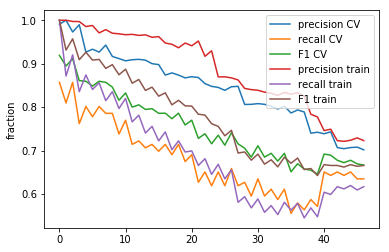

In [58]:
# We can plot the different metrics of the test and validation set as a function of k
# Get the precisions for class 1 (there is a bird)
precision_cv = [x[1] for (x,y,z) in scores_cv]
recall_cv = [y[1] for (x,y,z) in scores_cv]
f1_cv = [z[1] for (x,y,z) in scores_cv]

precision_train = [x[1] for (x,y,z) in scores_train]
recall_train = [y[1] for (x,y,z) in scores_train]
f1_train = [z[1] for (x,y,z) in scores_train]

plt.plot(precision_cv)
plt.plot(recall_cv)
plt.plot(f1_cv)

plt.plot(precision_train)
plt.plot(recall_train)
plt.plot(f1_train)

plt.ylabel('fraction')
plt.legend(['precision CV', 'recall CV', 'F1 CV','precision train', 'recall train', 'F1 train'], loc='upper right')
plt.show()

In [129]:
knn = KNeighborsClassifier(n_neighbors=1, algorithm = 'auto')
knn.fit(X_train, y_train)
y_cv_pred = knn.predict(X_cv)
print(classification_report(y_cv, y_cv_pred))
type(classification_report(y_cv, y_cv_pred))

             precision    recall  f1-score   support

          0       0.97      1.00      0.99       646
          1       0.99      0.86      0.92       126

avg / total       0.98      0.98      0.97       772



str

In [130]:
f1_score(y_cv, y_cv_pred)

0.91914893617021287

# Neural Network with Tensorflow - ongoing

In [131]:
import tensorflow as tf
# The labels need to be 1-hot encoded.. which they are currently not. 
print(X_train[0].shape)

(2592,)


In [132]:
x = tf.placeholder(tf.float32, [None, 2592])
W = tf.Variable(tf.zeros([2592, 2]))
b = tf.Variable(tf.zeros([2]))
y = tf.nn.softmax(tf.matmul(x,W)+b)